In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download -d nirmalsankalana/sugarcane-leaf-disease-dataset

100% 160M/160M [00:05<00:00, 29.4MB/s]
100% 160M/160M [00:05<00:00, 28.0MB/s]


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image,  ImageTk
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import cv2

import os


In [ ]:
import zipfile
import os

zip_file = "/content/sugarcane-leaf-disease-dataset.zip"
extract_folder = "extracted_folder"

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents of zip file in the specified directory
    zip_ref.extractall(extract_folder)

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [ ]:
#Loading the dataset from Google Drive

dataset_path = '/content/extracted_folder'

target_size = (125, 125)
dataset = []
labels = []

for label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, label)

        if os.path.isdir(class_path):
          images_counter = 0

        #Iterating over all the images in a folder
        for img_name in os.listdir(class_path):
          img_path = os.path.join(class_path, img_name)

          image = cv2.imread(img_path)
          # Check if the image was loaded successfully
          if image is not None:
              # Resize the image
              image = cv2.resize(image, target_size)

              # Add image and label to dataset
              dataset.append(image)
              labels.append(label)


          else:
              print(f"Error loading image: {img_path}")

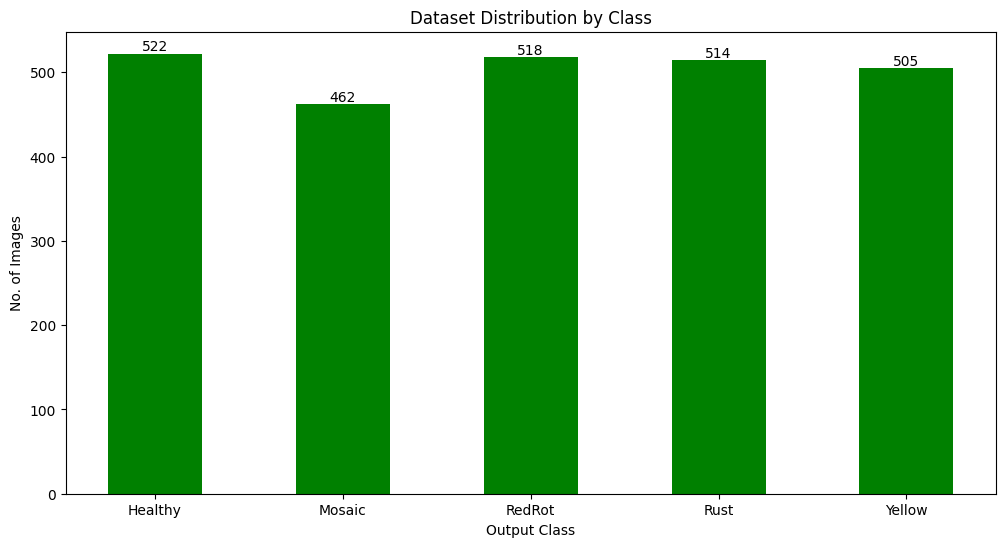

In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_counts.keys(), class_counts.values(), color='green', width = 0.5)
ax.set_xlabel('Output Class')
ax.set_ylabel('No. of Images')

ax.set_title('Dataset Distribution by Class')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()

In [ ]:
import random

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))

    labels_array = np.array(labels)
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels_array == class_name)[0]

        if len(indices_class) > 0:
            sample_index = random.choice(indices_class)
        else:
            continue

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

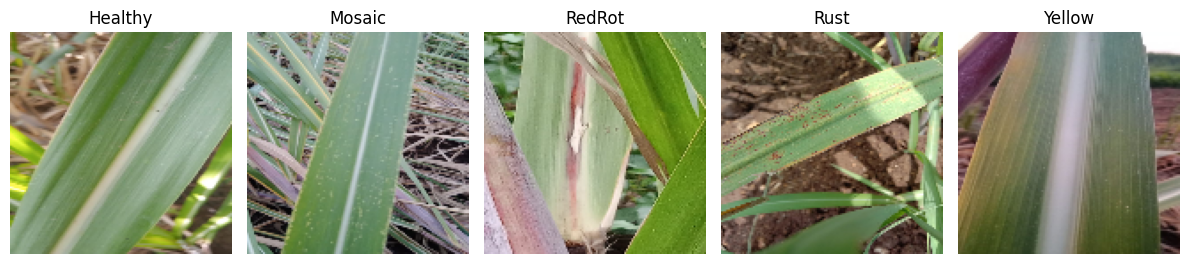

In [ ]:
unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into 60% train, 40% rest
X_train, X_rest, y_train, y_rest = train_test_split(dataset, encoded_labels, test_size=0.4, random_state=42)

# Split the rest into 50% validation and 50% test
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

def preprocess_image(image):
    resized_image = cv2.resize(image, (125, 125))

    # Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training, validation, and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_val = np.array([preprocess_image(image) for image in X_val])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training, validation, and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1512, 125, 125, 3)
Shape of X_val: (504, 125, 125, 3)
Shape of X_test: (505, 125, 125, 3)
Shape of y_train: (1512,)
Shape of y_val: (504,)
Shape of y_test: (505,)


In [ ]:

!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop


In [ ]:
num_classes = len(np.unique(labels))

model = models.Sequential()

efficientnet_model = EfficientNetB0(input_shape=(125, 125, 3), include_top=False, weights='imagenet', pooling='max')

model.add(efficientnet_model)

model.add(Dense(128, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
custom_optimizer = RMSprop(learning_rate=0.0001)

model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/50
48/48 [==============================] - 160s 3s/step - loss: 3.3489 - accuracy: 0.2255 - val_loss: 2.2830 - val_accuracy: 0.2455
Epoch 2/50
48/48 [==============================] - 130s 3s/step - loss: 2.4549 - accuracy: 0.2870 - val_loss: 2.2047 - val_accuracy: 0.3030
Epoch 3/50
48/48 [==============================] - 130s 3s/step - loss: 2.2655 - accuracy: 0.3532 - val_loss: 2.1293 - val_accuracy: 0.3347
Epoch 4/50
48/48 [==============================] - 129s 3s/step - loss: 2.1469 - accuracy: 0.4048 - val_loss: 1.9781 - val_accuracy: 0.4574
Epoch 5/50
48/48 [==============================] - 132s 3s/step - loss: 1.9636 - accuracy: 0.4722 - val_loss: 1.8203 - val_accuracy: 0.5426
Epoch 6/50
48/48 [==============================] - 130s 3s/step - loss: 1.8843 - accuracy: 0.5013 - val_loss: 1.7166 - val_accuracy: 0.5861
Epoch 7/50
48/48 [==============================] - 130s 3s/step - loss: 1.7662 - accurac

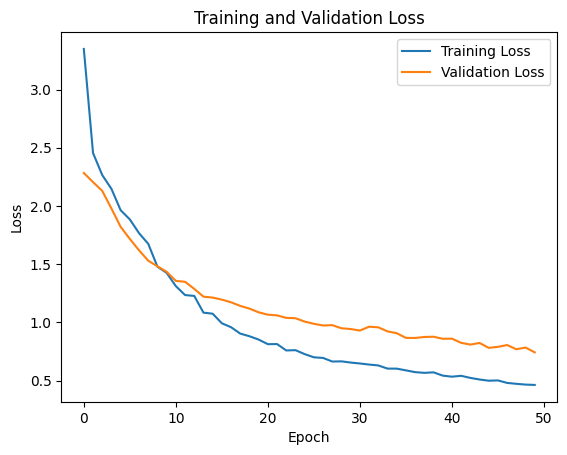

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

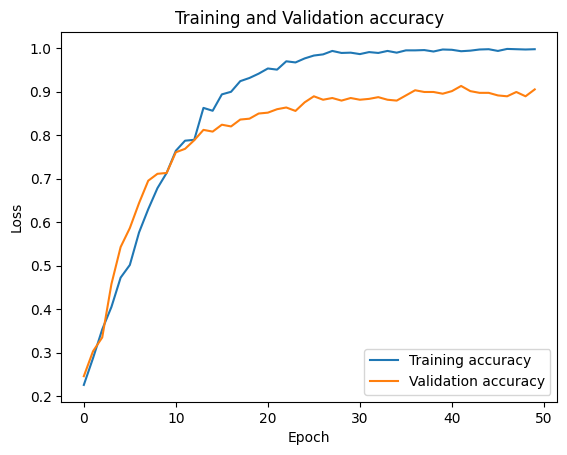

In [ ]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 14s 665ms/step


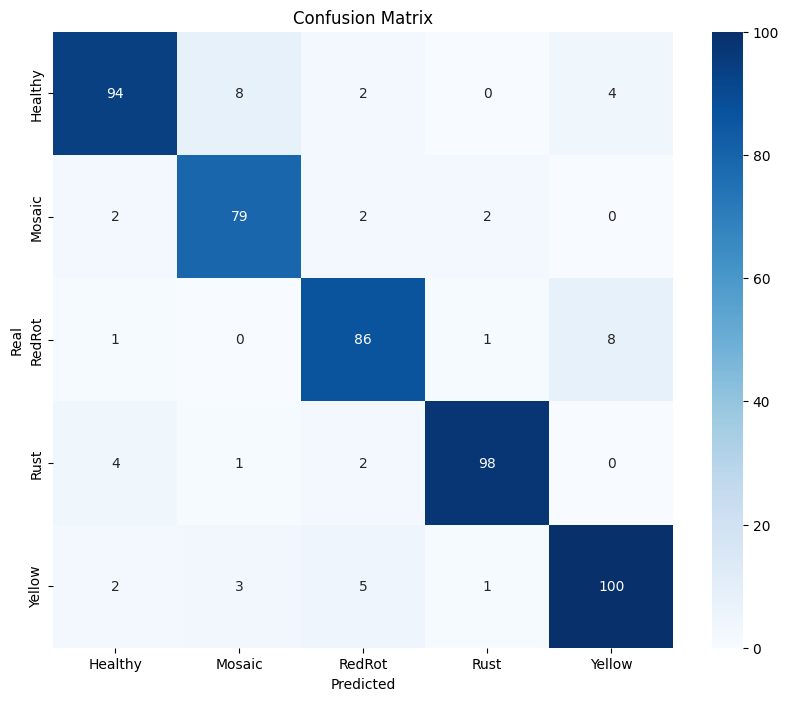

              precision    recall  f1-score   support

     Healthy       0.91      0.87      0.89       108
      Mosaic       0.87      0.93      0.90        85
      RedRot       0.89      0.90      0.89        96
        Rust       0.96      0.93      0.95       105
      Yellow       0.89      0.90      0.90       111

    accuracy                           0.90       505
   macro avg       0.90      0.91      0.90       505
weighted avg       0.91      0.90      0.91       505



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))